# Final Simulation of Singular Routes

In [ ]:
import main_1 as m
import models.road_network.create_graph as cg
import models.vehicle_models.battery_deg as bd
import scipy.stats as stats
import random

import json
from pprint import pprint
import matplotlib.pyplot as plt
import simulation.simulate_routes as sr
import datetime
import os
import numpy as np

In [ ]:
road_network_file, road_df, static_data, vehicle_data, battery_data, map_data, weights = m.import_data()

In [ ]:
OCV = battery_data["OCV"]
capacity = battery_data["Capacity"]
R_int = battery_data["R_internal"]
motor_eff = vehicle_data["motor_eff"]
graph = cg.create_osmnx_compatible_graph(road_network_file, debug = False)

In [ ]:
with open("test_data/test_route_set.json", "r") as file:
        test_routes_dict = json.load(file)

Simulate a cycle of charge - down to 80% DoD

In [ ]:
def find_next_capacity(start_cap, consumption):
        loss = consumption/OCV
        cap = start_cap - loss
        return cap

In [ ]:
import random

def simulate_full_discharge(sim_results, initial_capacity):
    results_dict = {}
    cap_loss_distance = []
    battery_capacity = []
    distance_travelled = []

    # Initialize with your starting capacity
    current_capacity = initial_capacity  # Use your initial capacity value

    # Create a list of all routes to process
    all_routes = []
    for key, values in sim_results.items():
        for test, test_data in values.items():
            if 'distance' in test:
                for id, item in test_data.items():
                    all_routes.append((key, test, test_data))
                    break
    # Shuffle the routes randomly
    random.shuffle(all_routes)

    # Process routes one by one until capacity drops below threshold
    route_index = 0
    while current_capacity >= capacity * 0.2 and route_index < len(all_routes):
        key, test, test_data = all_routes[route_index]
        
        # Initialize dictionary entries if needed
        if key not in results_dict:
            results_dict[key] = {}
        results_dict[key][test] = {}
        
        # Calculate capacity loss using the current capacity value
        capacity_loss = bd.route_analysis(
            test_data['detailed_results'], 
            test_data['current_list'], 
            test_data['consumptions'],
            OCV, 
            current_capacity,
            base_k = 0.2,
            c_rate_exp = 0.2286
        )
        # Store results
        cap_loss_distance.append(capacity_loss)
        results_dict[key][test]['capacity_loss'] = capacity_loss
        results_dict[key][test]['consumption'] = test_data['total_consumption']

        distance_travelled.append(test_data['total_distance'])

        # Update capacity for the next route
        current_capacity = find_next_capacity(current_capacity, test_data['total_consumption'])
        battery_capacity.append(current_capacity)
        
        # Move to next route
        route_index += 1
    
    return results_dict, current_capacity, cap_loss_distance

In [ ]:
with open("results/singular_routes_sim/simulation_test_set1.json", "r") as file:
    sim_results = json.load(file)


results_dict, current_capacity, cap_loss_distance = simulate_full_discharge(sim_results, capacity)
print(sum(cap_loss_distance))


In [ ]:
def simulate_cycles(initial_capacity):
    cap  = initial_capacity
    losses = []
    deg = []

    for i in range(600):
        results_dict, current_capacity, cap_loss_distance = simulate_full_discharge(sim_results, cap)

        cap -= sum(cap_loss_distance)
        losses.append(sum(cap_loss_distance))
        deg.append(cap)
    return deg, losses
    
degradation, losses = simulate_cycles(capacity)

In [ ]:
print(len(losses))
print(np.average(losses))
print(sum(losses))
plt.plot(range(len(degradation)), degradation)
plt.show()

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def get_routes_sequence(sim_results, route_type="distance"):
    """
    Extract and randomly shuffle routes of a specific type from sim_results.
    
    Parameters:
    sim_results (dict): Dictionary containing all simulation results
    route_type (str): Type of routes to extract (e.g., 'distance', 'optimised')
    
    Returns:
    list: Shuffled list of route tuples (key, test, test_data)
    """
    all_routes = []
    
    for key, values in sim_results.items():
        for test, test_data in values.items():
            if route_type in test:
                for id, item in test_data.items():
                    all_routes.append((key, test, test_data))
                    break
    
    # Shuffle the routes randomly
    random.shuffle(all_routes)
    return all_routes

def simulate_discharge_for_route_type(sim_results, initial_capacity, route_type="distance", seed=None):
    """
    Simulate battery discharge for a specific route type.
    
    Parameters:
    sim_results (dict): Dictionary containing all simulation results
    initial_capacity (float): Initial battery capacity
    route_type (str): Type of routes to use (e.g., 'distance', 'optimised')
    seed (int): Random seed for route shuffling (None for random, value for deterministic)
    
    Returns:
    tuple: (results_dict, final_capacity, cap_loss_list, battery_capacity_list, distance_travelled_list)
    """
    results_dict = {}
    cap_loss_list = []
    battery_capacity = []
    distance_travelled = []
    
    # Set random seed if provided
    if seed is not None:
        random.seed(seed)
    
    # Get routes for this simulation
    all_routes = get_routes_sequence(sim_results, route_type)
    
    # Initialize with starting capacity
    current_capacity = initial_capacity
    
    # Process routes one by one until capacity drops below threshold
    route_index = 0
    while current_capacity >= initial_capacity * 0.2 and route_index < len(all_routes):
        key, test, test_data = all_routes[route_index]
        
        # Initialize dictionary entries if needed
        if key not in results_dict:
            results_dict[key] = {}
        results_dict[key][test] = {}
        
        # Calculate capacity loss using the current capacity value
        capacity_loss = 2 * bd.route_analysis(
            test_data['detailed_results'], 
            test_data['current_list'], 
            test_data['consumptions'],
            OCV, 
            current_capacity,
            base_k = 0.012,
            c_rate_exp = 0.8
        )
        
        # Store results
        cap_loss_list.append(capacity_loss)
        results_dict[key][test]['capacity_loss'] = capacity_loss
        results_dict[key][test]['consumption'] = test_data['total_consumption']
        distance_travelled.append(test_data['total_distance'])
        
        # Update capacity for the next route
        current_capacity = find_next_capacity(current_capacity, test_data['total_consumption'])
        battery_capacity.append(current_capacity)
        
        # Move to next route
        route_index += 1
    
    return results_dict, current_capacity, cap_loss_list, battery_capacity, distance_travelled

def compare_discharge_simulations(sim_results, regular_capacity, optimised_capacity):
    """
    Compare battery discharge for both regular and optimized routes using the same random sequence.
    
    Parameters:
    sim_results (dict): Dictionary containing all simulation results
    regular_capacity (float): Current capacity for regular routes simulation
    optimised_capacity (float): Current capacity for optimised routes simulation
    
    Returns:
    dict: Combined results from both simulations
    """
    # Use a fixed seed for reproducibility and to ensure both simulations use the same random sequence
    random_seed = random.randint(0, 9999)
    
    # Run simulation for regular distance routes
    results_dict_regular, final_capacity_regular, cap_loss_regular, \
    battery_capacity_regular, distance_travelled_regular = simulate_discharge_for_route_type(
        sim_results, regular_capacity, route_type="distance", seed=random_seed
    )
    
    # Run simulation for optimised routes with the same seed
    results_dict_optimised, final_capacity_optimised, cap_loss_optimised, \
    battery_capacity_optimised, distance_travelled_optimised = simulate_discharge_for_route_type(
        sim_results, optimised_capacity, route_type="optimised", seed=random_seed
    )
    
    # Combine results for comparison
    comparison_results = {
        'regular': {
            'results_dict': results_dict_regular,
            'final_capacity': final_capacity_regular,
            'cap_loss_list': cap_loss_regular,
            'battery_capacity': battery_capacity_regular,
            'distance_travelled': distance_travelled_regular,
        },
        'optimised': {
            'results_dict': results_dict_optimised,
            'final_capacity': final_capacity_optimised,
            'cap_loss_list': cap_loss_optimised,
            'battery_capacity': battery_capacity_optimised,
            'distance_travelled': distance_travelled_optimised,
        }
    }
    
    return comparison_results

# Simulate multiple battery discharge cycles and track degradation
def simulate_cycles(sim_results, initial_capacity, num_cycles=600):
    """
    Simulate multiple battery discharge cycles, tracking degradation over time.
    
    Parameters:
    sim_results (dict): Dictionary containing all simulation results
    initial_capacity (float): Initial battery capacity
    num_cycles (int): Number of cycles to simulate
    
    Returns:
    tuple: (degradation_data, losses_data)
        - degradation_data: Dictionary with capacity over time for regular and optimized routes
        - losses_data: Dictionary with capacity losses for each cycle
    """
    # Initialize tracking variables
    regular_capacity = initial_capacity
    optimised_capacity = initial_capacity
    
    regular_degradation = [regular_capacity]
    optimised_degradation = [optimised_capacity]
    
    regular_losses = []
    optimised_losses = []
    
    cycle_numbers = [0]
    
    # Track termination status for each battery type
    regular_terminated = False
    optimised_terminated = False
    
    for cycle in range(1, num_cycles + 1):
        # Run simulations for this cycle
        # If a battery has reached termination threshold, we still simulate but won't update its capacity further
        comparison_results = compare_discharge_simulations(
            sim_results, 
            regular_capacity if not regular_terminated else initial_capacity * 0.2,
            optimised_capacity if not optimised_terminated else initial_capacity * 0.2
        )
        
        # Accumulate losses from this cycle
        regular_cycle_loss = sum(comparison_results['regular']['cap_loss_list']) if not regular_terminated else 0
        optimised_cycle_loss = sum(comparison_results['optimised']['cap_loss_list']) if not optimised_terminated else 0
        
        # Update capacities only if not terminated
        if not regular_terminated:
            regular_capacity -= regular_cycle_loss
            # Check if regular has now reached termination
            if regular_capacity < 0.2 * initial_capacity:
                regular_capacity = 0.2 * initial_capacity  # Floor at 20%
                regular_terminated = True
                print(f"Regular routes battery terminated at cycle {cycle}")
        
        if not optimised_terminated:
            optimised_capacity -= optimised_cycle_loss
            # Check if optimised has now reached termination
            if optimised_capacity < 0.2 * initial_capacity:
                optimised_capacity = 0.2 * initial_capacity  # Floor at 20%
                optimised_terminated = True
                print(f"Optimised routes battery terminated at cycle {cycle}")
        
        # Store data for this cycle
        regular_degradation.append(regular_capacity)
        optimised_degradation.append(optimised_capacity)
        regular_losses.append(regular_cycle_loss)
        optimised_losses.append(optimised_cycle_loss)
        cycle_numbers.append(cycle)
        
        # Terminate simulation only when both batteries have reached end of life
        if regular_terminated and optimised_terminated:
            print(f"Both batteries terminated. Ending simulation at cycle {cycle}")
            break
    
    # Compile results
    degradation_data = {
        'cycles': cycle_numbers,
        'regular_capacity': regular_degradation,
        'optimised_capacity': optimised_degradation,
        'capacity_percentage_regular': [cap/initial_capacity*100 for cap in regular_degradation],
        'capacity_percentage_optimised': [cap/initial_capacity*100 for cap in optimised_degradation]
    }
    
    losses_data = {
        'cycles': cycle_numbers[1:],
        'regular_losses': regular_losses,
        'optimised_losses': optimised_losses
    }
    
    return degradation_data, losses_data

def plot_degradation_comparison(degradation_data):
    """
    Plot the battery degradation comparison between regular and optimized routes.
    
    Parameters:
    degradation_data (dict): Dictionary containing degradation data from simulate_cycles
    """
    plt.figure(figsize=(10, 6))
    plt.plot(degradation_data['cycles'], degradation_data['capacity_percentage_regular'], 'b-', label='Regular Routes')
    plt.plot(degradation_data['cycles'], degradation_data['capacity_percentage_optimised'], 'g-', label='Optimised Routes')
    plt.xlabel('Cycle Number')
    plt.ylabel('Remaining Capacity (%)')
    plt.title('Battery Degradation Comparison')
    plt.legend()
    plt.grid(True)
    plt.axhline(y=20, color='r', linestyle='--', label='End of Life (20%)')
    plt.savefig('battery_degradation_comparison.png')
    plt.show()



In [ ]:
simulation1 = "results/singular_routes_sim/simulation_test_set1.json"
simulation2 = "results/singular_routes_sim/simulation_test_set2.json"
simulation3 = "results/singular_routes_sim/simulation_test_set3.json"
simulation4 = "results/singular_routes_sim/simulation_test_set4.json"
simulation5 = "results/singular_routes_sim/simulation_test_set5.json"
sims = [simulation1, simulation2, simulation3, simulation4, simulation5]

for sim in sims:
    with open(sim, "r") as file:
        simulation_results = json.load(file)

    degradation_data, losses_data = simulate_cycles(simulation_results, capacity, num_cycles=1500)
    plot_degradation_comparison(degradation_data)

In [267]:
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import os

def get_routes_sequence(sim_results, route_type="distance"):
    """
    Extract and randomly shuffle routes of a specific type from sim_results.
    
    Parameters:
    sim_results (dict): Dictionary containing all simulation results
    route_type (str): Type of routes to extract (e.g., 'distance', 'optimised')
    
    Returns:
    list: Shuffled list of route tuples (key, test, test_data)
    """
    all_routes = []
    
    for key, values in sim_results.items():
        for test, test_data in values.items():
            if route_type in test:
                for id, item in test_data.items():
                    all_routes.append((key, test, test_data))
                    break
    
    # Shuffle the routes randomly
    random.shuffle(all_routes)
    return all_routes

def simulate_discharge_for_route_type(sim_results, initial_capacity, route_type="distance", seed=None):
    """
    Simulate battery discharge for a specific route type.
    
    Parameters:
    sim_results (dict): Dictionary containing all simulation results
    initial_capacity (float): Initial battery capacity
    route_type (str): Type of routes to use (e.g., 'distance', 'optimised')
    seed (int): Random seed for route shuffling (None for random, value for deterministic)
    
    Returns:
    tuple: (results_dict, final_capacity, cap_loss_list, battery_capacity_list, distance_travelled_list)
    """
    results_dict = {}
    cap_loss_list = []
    battery_capacity = []
    distance_travelled = []
    
    # Set random seed if provided
    if seed is not None:
        random.seed(seed)
    
    # Get routes for this simulation
    all_routes = get_routes_sequence(sim_results, route_type)
    
    # Initialize with starting capacity
    current_capacity = initial_capacity
    
    # Process routes one by one until capacity drops below threshold
    route_index = 0
    while current_capacity >= initial_capacity * 0.6 and route_index < len(all_routes):
        key, test, test_data = all_routes[route_index]
        
        # Initialize dictionary entries if needed
        if key not in results_dict:
            results_dict[key] = {}
        results_dict[key][test] = {}
        
        # Calculate capacity loss using the current capacity value
        capacity_loss = 2 * bd.route_analysis(
            test_data['detailed_results'], 
            test_data['current_list'], 
            test_data['consumptions'],
            OCV, 
            current_capacity,
            base_k = 0.047,
            c_rate_exp = 1.2
        )
        
        # Store results
        cap_loss_list.append(capacity_loss)
        results_dict[key][test]['capacity_loss'] = capacity_loss
        results_dict[key][test]['consumption'] = test_data['total_consumption']
        distance_travelled.append(test_data['total_distance'])
        
        # Update capacity for the next route
        current_capacity = find_next_capacity(current_capacity, test_data['total_consumption'])
        battery_capacity.append(current_capacity)
        
        # Move to next route
        route_index += 1
    
    return results_dict, current_capacity, cap_loss_list, battery_capacity, distance_travelled

def compare_discharge_simulations(sim_results, regular_capacity, optimised_capacity, seed=None):
    """
    Compare battery discharge for both regular and optimized routes using the same random sequence.
    
    Parameters:
    sim_results (dict): Dictionary containing all simulation results
    regular_capacity (float): Current capacity for regular routes simulation
    optimised_capacity (float): Current capacity for optimised routes simulation
    seed (int): Random seed for reproducibility (None for random selection)
    
    Returns:
    dict: Combined results from both simulations
    """
    # Use a fixed seed for reproducibility and to ensure both simulations use the same random sequence
    if seed is None:
        random_seed = random.randint(0, 9999)
    else:
        random_seed = seed
    
    # Run simulation for regular distance routes
    results_dict_regular, final_capacity_regular, cap_loss_regular, \
    battery_capacity_regular, distance_travelled_regular = simulate_discharge_for_route_type(
        sim_results, regular_capacity, route_type="distance", seed=random_seed
    )
    
    # Run simulation for optimised routes with the same seed
    results_dict_optimised, final_capacity_optimised, cap_loss_optimised, \
    battery_capacity_optimised, distance_travelled_optimised = simulate_discharge_for_route_type(
        sim_results, optimised_capacity, route_type="optimised", seed=random_seed
    )
    
    # Combine results for comparison
    comparison_results = {
        'random_seed': random_seed,
        'regular': {
            'results_dict': results_dict_regular,
            'final_capacity': final_capacity_regular,
            'cap_loss_list': cap_loss_regular,
            'battery_capacity': battery_capacity_regular,
            'distance_travelled': distance_travelled_regular,
        },
        'optimised': {
            'results_dict': results_dict_optimised,
            'final_capacity': final_capacity_optimised,
            'cap_loss_list': cap_loss_optimised,
            'battery_capacity': battery_capacity_optimised,
            'distance_travelled': distance_travelled_optimised,
        }
    }
    
    return comparison_results

# Simulate multiple battery discharge cycles and track degradation
def simulate_cycles(sim_results, initial_capacity, num_cycles=600, seed=None):
    """
    Simulate multiple battery discharge cycles, tracking degradation over time.
    
    Parameters:
    sim_results (dict): Dictionary containing all simulation results
    initial_capacity (float): Initial battery capacity
    num_cycles (int): Number of cycles to simulate
    seed (int): Random seed for reproducibility (None for random selection)
    
    Returns:
    tuple: (degradation_data, losses_data)
        - degradation_data: Dictionary with capacity over time for regular and optimized routes
        - losses_data: Dictionary with capacity losses for each cycle
    """
    # Initialize tracking variables
    regular_capacity = initial_capacity
    optimised_capacity = initial_capacity
    
    regular_degradation = [regular_capacity]
    optimised_degradation = [optimised_capacity]
    
    regular_losses = []
    optimised_losses = []
    
    cycle_numbers = [0]
    
    # Track termination status for each battery type
    regular_terminated = False
    optimised_terminated = False
    
    for cycle in range(1, num_cycles + 1):
        # Run simulations for this cycle
        # If a battery has reached termination threshold, we still simulate but won't update its capacity further
        comparison_results = compare_discharge_simulations(
            sim_results, 
            regular_capacity if not regular_terminated else initial_capacity * 0.2,
            optimised_capacity if not optimised_terminated else initial_capacity * 0.2,
            seed=seed  # Pass the seed parameter
        )
        
        # Accumulate losses from this cycle
        regular_cycle_loss = sum(comparison_results['regular']['cap_loss_list']) if not regular_terminated else 0
        optimised_cycle_loss = sum(comparison_results['optimised']['cap_loss_list']) if not optimised_terminated else 0
        
        # Update capacities only if not terminated
        if not regular_terminated:
            regular_capacity -= regular_cycle_loss
            # Check if regular has now reached termination
            if regular_capacity < 0.2 * initial_capacity:
                regular_capacity = 0.2 * initial_capacity  # Floor at 20%
                regular_terminated = True
                print(f"Regular routes battery terminated at cycle {cycle}")
        
        if not optimised_terminated:
            optimised_capacity -= optimised_cycle_loss
            # Check if optimised has now reached termination
            if optimised_capacity < 0.2 * initial_capacity:
                optimised_capacity = 0.2 * initial_capacity  # Floor at 20%
                optimised_terminated = True
                print(f"Optimised routes battery terminated at cycle {cycle}")
        
        # Store data for this cycle
        regular_degradation.append(regular_capacity)
        optimised_degradation.append(optimised_capacity)
        regular_losses.append(regular_cycle_loss)
        optimised_losses.append(optimised_cycle_loss)
        cycle_numbers.append(cycle)
        
        # Terminate simulation only when both batteries have reached end of life
        if regular_terminated and optimised_terminated:
            print(f"Both batteries terminated. Ending simulation at cycle {cycle}")
            break
    
    # Compile results
    degradation_data = {
        'cycles': cycle_numbers,
        'regular_capacity': regular_degradation,
        'optimised_capacity': optimised_degradation,
        'capacity_percentage_regular': [cap/initial_capacity*100 for cap in regular_degradation],
        'capacity_percentage_optimised': [cap/initial_capacity*100 for cap in optimised_degradation],
        'random_seed': seed
    }
    
    losses_data = {
        'cycles': cycle_numbers[1:],
        'regular_losses': regular_losses,
        'optimised_losses': optimised_losses,
        'random_seed': seed
    }
    
    return degradation_data, losses_data

def plot_degradation_comparison(degradation_data, seed=None):
    """
    Plot the battery degradation comparison between regular and optimized routes.
    
    Parameters:
    degradation_data (dict): Dictionary containing degradation data from simulate_cycles
    seed (int): Random seed used for this simulation (for labeling)
    """
    plt.figure(figsize=(10, 6))
    plt.plot(degradation_data['cycles'], degradation_data['capacity_percentage_regular'], 'b-', label='Regular Routes')
    plt.plot(degradation_data['cycles'], degradation_data['capacity_percentage_optimised'], 'g-', label='Optimised Routes')
    plt.xlabel('Cycle Number')
    plt.ylabel('Remaining Capacity (%)')
    
    seed_info = f"Seed: {seed}" if seed is not None else ""
    plt.title(f'Battery Degradation Comparison {seed_info}')
    
    plt.legend()
    plt.grid(True)
    plt.axhline(y=60, color='r', linestyle='--', label='End of Life (60%)')
    plt.show()

def run_multiple_random_simulations(simulation_file, capacity, num_cycles=1500, num_random_sets=5, show_individual_plots=False):
    """
    Run multiple random simulations for a given simulation file.
    
    Parameters:
    simulation_file (str): Path to the simulation JSON file
    capacity (float): Initial battery capacity
    num_cycles (int): Number of cycles to simulate
    num_random_sets (int): Number of random sets to generate
    show_individual_plots (bool): Whether to show individual plots for each random set
    """
    # Load simulation data
    with open(simulation_file, "r") as file:
        simulation_results = json.load(file)
    
    sim_name = os.path.basename(simulation_file).replace(".json", "")
    
    all_degradation_data = []
    all_losses_data = []
    
    # Run multiple random simulations
    for i in range(num_random_sets):
        # Generate a unique seed for this simulation
        seed = random.randint(0, 99999)
        print(f"Running simulation {sim_name}, random set {i+1}/{num_random_sets} with seed {seed}")
        
        # Run the simulation with this seed
        degradation_data, losses_data = simulate_cycles(
            simulation_results, 
            capacity, 
            num_cycles=num_cycles,
            seed=seed
        )
        
        # Add to collection of all results
        all_degradation_data.append(degradation_data)
        all_losses_data.append(losses_data)
        
        # Plot individual result if requested
        if show_individual_plots:
            plot_degradation_comparison(
                degradation_data,
                seed=seed
            )
    
    return all_degradation_data, all_losses_data

def plot_combined_degradation(all_degradation_data, sim_name):
    """
    Plot all degradation curves on a single plot for comparison.
    
    Parameters:
    all_degradation_data (list): List of degradation data dictionaries
    sim_name (str): Name of the simulation for the plot title
    """
    plt.figure(figsize=(12, 8))
    
    # Plot each set with slightly transparent lines
    for i, degradation_data in enumerate(all_degradation_data):
        seed = degradation_data.get('random_seed', f"Set {i+1}")
        
        # Regular routes in blue shades
        plt.plot(
            degradation_data['cycles'], 
            degradation_data['capacity_percentage_regular'], 
            'b-', 
            alpha=0.3, 
            label=f"Regular (Seed {seed})" if i == 0 else ""
        )
        
        # Optimized routes in green shades
        plt.plot(
            degradation_data['cycles'], 
            degradation_data['capacity_percentage_optimised'], 
            'g-', 
            alpha=0.3, 
            label=f"Optimised (Seed {seed})" if i == 0 else ""
        )
    
    # If we have multiple data sets, calculate and plot averages
    if len(all_degradation_data) > 1:
        # Calculate average degradation curves
        max_cycles = max([max(data['cycles']) for data in all_degradation_data])
        avg_cycles = list(range(0, int(max_cycles) + 1))
        
        # Initialize arrays for summing up values
        sum_regular = np.zeros(len(avg_cycles))
        sum_optimised = np.zeros(len(avg_cycles))
        count_regular = np.zeros(len(avg_cycles))
        count_optimised = np.zeros(len(avg_cycles))
        
        # Sum up all values for each cycle
        for data in all_degradation_data:
            for i, cycle in enumerate(data['cycles']):
                if cycle < len(avg_cycles):
                    sum_regular[cycle] += data['capacity_percentage_regular'][i]
                    sum_optimised[cycle] += data['capacity_percentage_optimised'][i]
                    count_regular[cycle] += 1
                    count_optimised[cycle] += 1
        
        # Calculate averages (avoiding division by zero)
        avg_regular = np.divide(sum_regular, count_regular, out=np.zeros_like(sum_regular), where=count_regular!=0)
        avg_optimised = np.divide(sum_optimised, count_optimised, out=np.zeros_like(sum_optimised), where=count_optimised!=0)
        
        # Plot averages with thicker lines
        plt.plot(avg_cycles, avg_regular, 'b-', linewidth=2, label='Average Regular')
        plt.plot(avg_cycles, avg_optimised, 'g-', linewidth=2, label='Average Optimised')
    
    plt.xlabel('Cycle Number')
    plt.ylabel('Remaining Capacity (%)')
    plt.title(f'Battery Degradation Comparison - {sim_name} (All Random Sets)')
    plt.legend()
    plt.grid(True)
    plt.axhline(y=60, color='r', linestyle='--', label='End of Life (60%)')
    plt.show()

# Example usage
def main():
    # Just use the first simulation file
    simulation_file = "results/singular_routes_sim/simulation_test_set1.json"
    
    sim_name = os.path.basename(simulation_file).replace(".json", "")
    print(f"\nProcessing simulation file: {simulation_file}")
    
    # Run 100 random simulations without showing individual plots (would be too many)
    all_degradation, all_losses = run_multiple_random_simulations(
        simulation_file,
        capacity,
        num_cycles=1500,
        num_random_sets=100,
        show_individual_plots=False
    )

    print(f"Completed processing for {sim_name} with 100 random route sets")

    return all_degradation, sim_name
    

In [268]:
all_degradation, sim_name = main()


Processing simulation file: results/singular_routes_sim/simulation_test_set1.json
Running simulation simulation_test_set1, random set 1/100 with seed 86987
Regular routes battery terminated at cycle 721
Optimised routes battery terminated at cycle 848
Both batteries terminated. Ending simulation at cycle 848
Running simulation simulation_test_set1, random set 2/100 with seed 76472
Regular routes battery terminated at cycle 646
Optimised routes battery terminated at cycle 702
Both batteries terminated. Ending simulation at cycle 702
Running simulation simulation_test_set1, random set 3/100 with seed 47904
Regular routes battery terminated at cycle 755
Optimised routes battery terminated at cycle 842
Both batteries terminated. Ending simulation at cycle 842
Running simulation simulation_test_set1, random set 4/100 with seed 88136
Regular routes battery terminated at cycle 637
Optimised routes battery terminated at cycle 893
Both batteries terminated. Ending simulation at cycle 893
Runni

Non-Optimised Algorithm reaches 80% capacity at cycle 301.64
Optimised Algorithm reaches 80% capacity at cycle 332.08


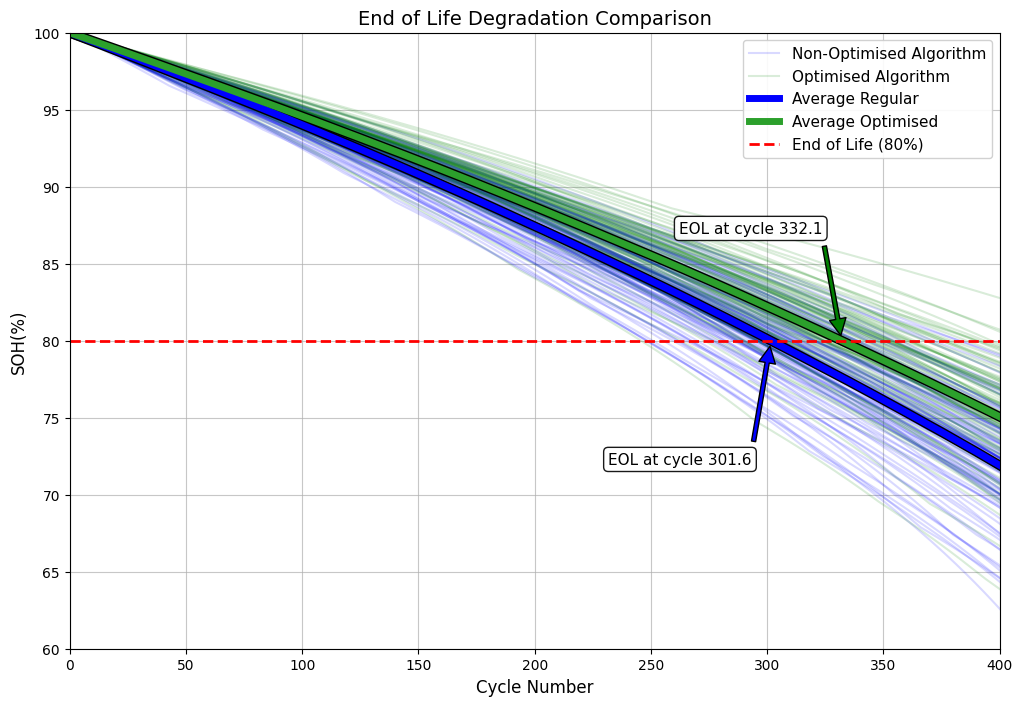

In [285]:
def plot_combined_degradation(all_degradation_data, sim_name):
    """
    Plot all degradation curves on a single plot for comparison.
    
    Parameters:
    all_degradation_data (list): List of degradation data dictionaries
    sim_name (str): Name of the simulation for the plot title
    """
    plt.figure(figsize=(12, 8))
    
            # Plot each set with slightly transparent lines
    for i, degradation_data in enumerate(all_degradation_data):
        seed = degradation_data.get('random_seed', f"Set {i+1}")
        
        # Regular routes in blue shades
        plt.plot(
            degradation_data['cycles'], 
            degradation_data['capacity_percentage_regular'], 
            'b-', 
            alpha=0.15, 
            label=f"Non-Optimised Algorithm" if i == 0 else ""
        )
        
        # Optimized routes in green shades
        plt.plot(
            degradation_data['cycles'], 
            degradation_data['capacity_percentage_optimised'], 
            'g-', 
            alpha=0.15, 
            label=f"Optimised Algorithm" if i == 0 else ""
        )
    
    # If we have multiple data sets, calculate and plot averages
    if len(all_degradation_data) > 1:
        # Calculate average degradation curves
        max_cycles = max([max(data['cycles']) for data in all_degradation_data])
        avg_cycles = list(range(0, int(max_cycles) + 1))
        
        # Initialize arrays for summing up values
        sum_regular = np.zeros(len(avg_cycles))
        sum_optimised = np.zeros(len(avg_cycles))
        count_regular = np.zeros(len(avg_cycles))
        count_optimised = np.zeros(len(avg_cycles))
        
        # Sum up all values for each cycle
        for data in all_degradation_data:
            for i, cycle in enumerate(data['cycles']):
                if cycle < len(avg_cycles):
                    sum_regular[cycle] += data['capacity_percentage_regular'][i]
                    sum_optimised[cycle] += data['capacity_percentage_optimised'][i]
                    count_regular[cycle] += 1
                    count_optimised[cycle] += 1
        
        # Calculate averages (avoiding division by zero)
        avg_regular = np.divide(sum_regular, count_regular, out=np.zeros_like(sum_regular), where=count_regular!=0)
        avg_optimised = np.divide(sum_optimised, count_optimised, out=np.zeros_like(sum_optimised), where=count_optimised!=0)
        
        # Plot averages with VERY visible lines
        # First plot wider black outline
        plt.plot(avg_cycles, avg_regular, color='black', linewidth=7, linestyle='-')
        plt.plot(avg_cycles, avg_optimised, color='black', linewidth=7, linestyle='-')
        
        # Then plot the colored lines on top - thicker and solid
        plt.plot(avg_cycles, avg_regular, color='blue', linewidth=5, linestyle='-', label='Average Regular')
        plt.plot(avg_cycles, avg_optimised, color='C2', linewidth=5, linestyle='-', label='Average Optimised')
        
        # Find where each average line crosses the 80% threshold
        regular_cross_point = None
        optimised_cross_point = None
        
        # Find first point where the value drops below 80%
        for i in range(len(avg_cycles)):
            # For regular algorithm
            if avg_regular[i] <= 80 and (i == 0 or avg_regular[i-1] > 80):
                # Linear interpolation for more accurate crossing point
                if i > 0:
                    y0, y1 = avg_regular[i-1], avg_regular[i]
                    x0, x1 = avg_cycles[i-1], avg_cycles[i]
                    regular_cross_point = x0 + (x1 - x0) * (80 - y0) / (y1 - y0)
                else:
                    regular_cross_point = avg_cycles[i]
            
            # For optimised algorithm
            if avg_optimised[i] <= 80 and (i == 0 or avg_optimised[i-1] > 80):
                # Linear interpolation for more accurate crossing point
                if i > 0:
                    y0, y1 = avg_optimised[i-1], avg_optimised[i]
                    x0, x1 = avg_cycles[i-1], avg_cycles[i]
                    optimised_cross_point = x0 + (x1 - x0) * (80 - y0) / (y1 - y0)
                else:
                    optimised_cross_point = avg_cycles[i]
        
        # Print where the lines cross 80%
        if regular_cross_point is not None:
            print(f"Non-Optimised Algorithm reaches 80% capacity at cycle {regular_cross_point:.2f}")
            # Add annotation to the plot with improved visibility and arrow
            plt.annotate(f"EOL at cycle {regular_cross_point:.1f}",
                         xy=(regular_cross_point, 80),
                         xytext=(regular_cross_point-70, 72),
                         arrowprops=dict(facecolor='blue', edgecolor='black', shrink=0.05, width=3),
                         fontsize=11,
                         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, edgecolor='black'))
        else:
            print("Non-Optimised Algorithm does not reach 80% capacity in the given data")
        
        if optimised_cross_point is not None:
            print(f"Optimised Algorithm reaches 80% capacity at cycle {optimised_cross_point:.2f}")
            # Add annotation to the plot with improved visibility
            plt.annotate(f"EOL at cycle {optimised_cross_point:.1f}",
                         xy=(optimised_cross_point, 80),
                         xytext=(optimised_cross_point-70, 87),
                         arrowprops=dict(facecolor='green', edgecolor='black', shrink=0.05, width=3),
                         fontsize=11,
                         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, edgecolor='black'))
        else:
            print("Optimised Algorithm does not reach 80% capacity in the given data")
    
    plt.xlabel('Cycle Number', fontsize=12)
    plt.ylabel('SOH(%)', fontsize=12)
    plt.ylim(60, 100)
    plt.xlim(0, 400)

    plt.title(f'End of Life Degradation Comparison', fontsize=14)
    plt.axhline(y=80, color='r', linestyle='--', linewidth=2, label='End of Life (80%)')
    plt.legend(fontsize=11, loc='upper right', framealpha=0.9)
    plt.grid(True, alpha=0.7)

    plt.show()


# Call the function
plot_combined_degradation(all_degradation, sim_name)